Import packages

In [1]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize=(10, 6)
export_dir = './'
data_dir = '../data/'

sns.set()
sns.set_context("paper")

2023-04-01 23:30:37.367703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 23:30:37.474366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/nvidia:/home/denso/.mujoco/mujoco210/bin:/usr/lib/nvidia-450:/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.2/lib64:/home/denso/.mujoco/mujoco200/bin
2023-04-01 23:30:37.474384: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-01 23:30:37.499379: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unab

Turn eventfiles into dictionaries

In [2]:
def get_section_results(file, policy_name, *tags):
    data_dict = {'env_step': [], 'policy': []}
    data_dict.update({tag: [] for tag in tags})
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    data_dict['env_step'].append(e.step)
                    data_dict['policy'].append(policy_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

Read eventfiles and output pandas DataFrame for evaluation data

In [3]:
def read_evaluation_data(policy_name, size, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for folder in os.scandir(os.path.join(data_dir, policy_name, 'logs')):
        if folder.is_dir():
            logdir = os.path.join(folder, 'tb_1', 'events*')
            eventfile = glob.glob(logdir)[0]
            data_dict = get_section_results(eventfile, policy_name, 'input_info/advantage', 'input_info/clip_range', 'input_info/discounted_rewards',\
                                             'input_info/learning_rate','loss/approximate_kullback-leibler', 'loss/clip_factor', 'loss/entropy_loss',\
                                             'loss/loss' ,'loss/policy_gradient_loss', 'loss/value_function_loss')
            data = pd.DataFrame(data_dict)
            for (columnName, columnData) in data.items():
                if columnName != 'env_step' and columnName != 'policy':
                    data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

            # reduce size for plotting
            count_row = data.shape[0]
            reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
            data_p = data.iloc[reduced_row]

            full_data = pd.concat([full_data, data], axis=0)
            plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

Read evaluation data

In [4]:
PP_s5, PP_s5_plot = read_evaluation_data('PP_TTT_20M_s5',500,0.002)
PP_s3, PP_s3_plot = read_evaluation_data('PP_TTT_20M_s3',500,0.002)
SP_s8, SP_s8_plot = read_evaluation_data('SP_TTT_20M_s8',500,0.002)

data_plot = pd.concat([SP_s8_plot, PP_s3_plot, PP_s5_plot], axis=0)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Plot advantages

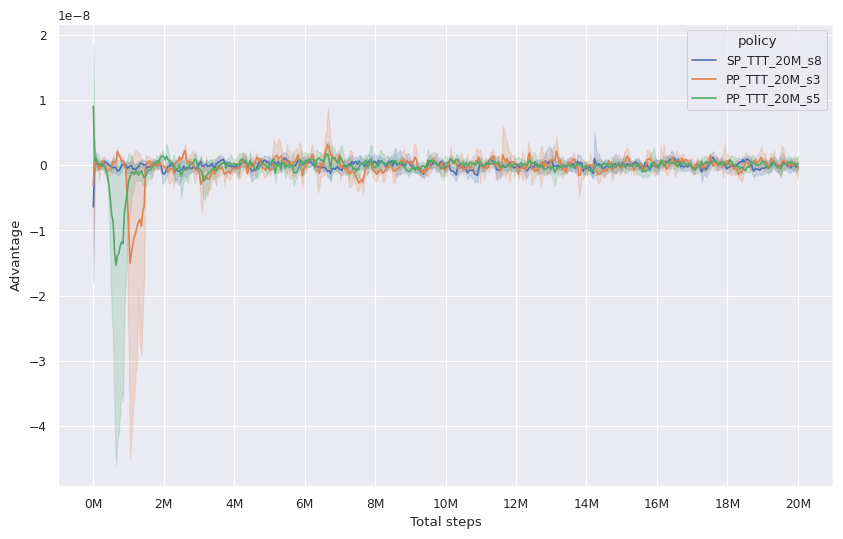

In [5]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='input_info/advantage_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Advantage')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_advantage.pdf'), bbox_inches='tight')

Plot discounted rewards

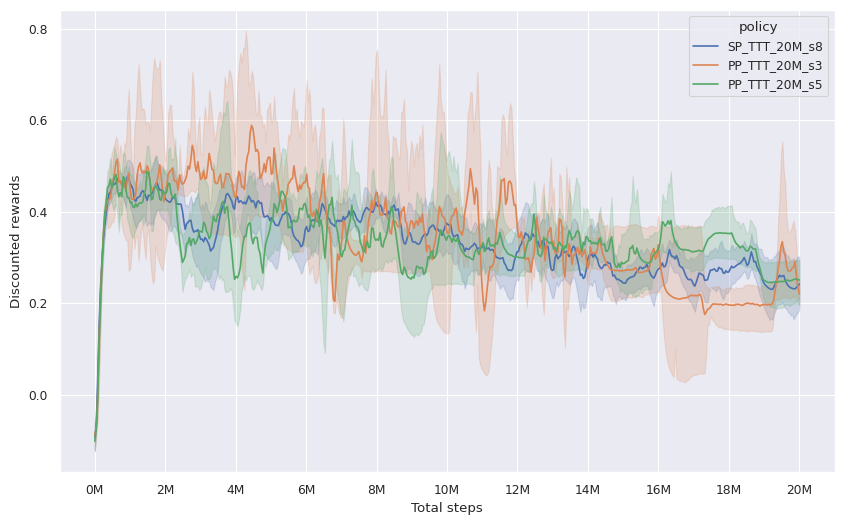

In [6]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='input_info/discounted_rewards_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Discounted rewards')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_discounted_reward.pdf'), bbox_inches='tight')

Plot loss

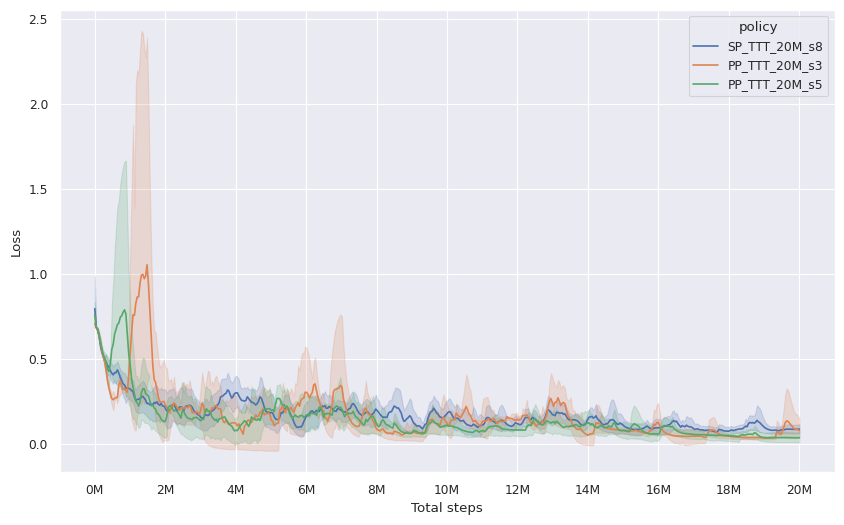

In [7]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_loss.pdf'), bbox_inches='tight')

Plot approximate KL

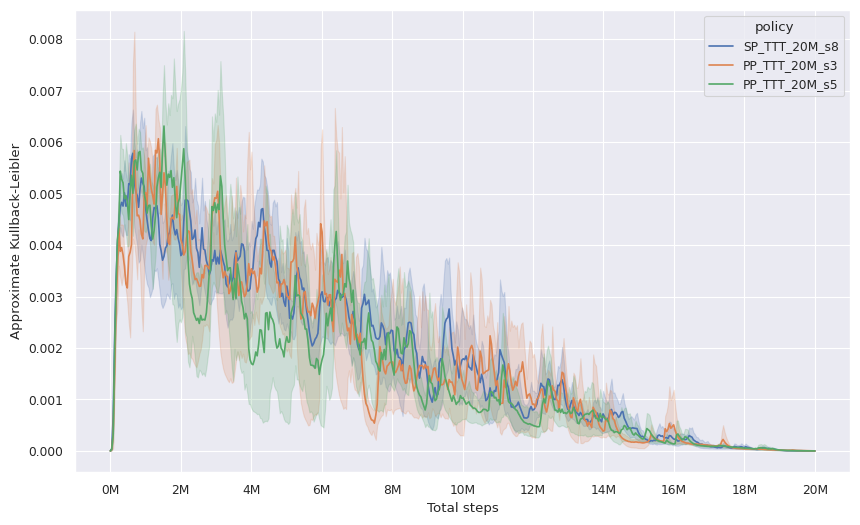

In [8]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/approximate_kullback-leibler_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Approximate Kullback-Leibler')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_approx_kl.pdf'), bbox_inches='tight')

Plot entropy loss

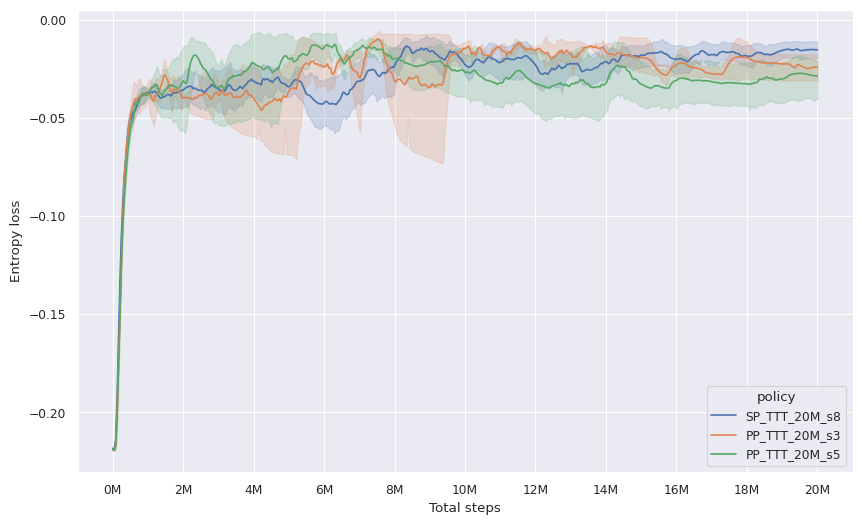

In [9]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/entropy_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Entropy loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_entropy_loss.pdf'), bbox_inches='tight')

Plot policy gradient loss

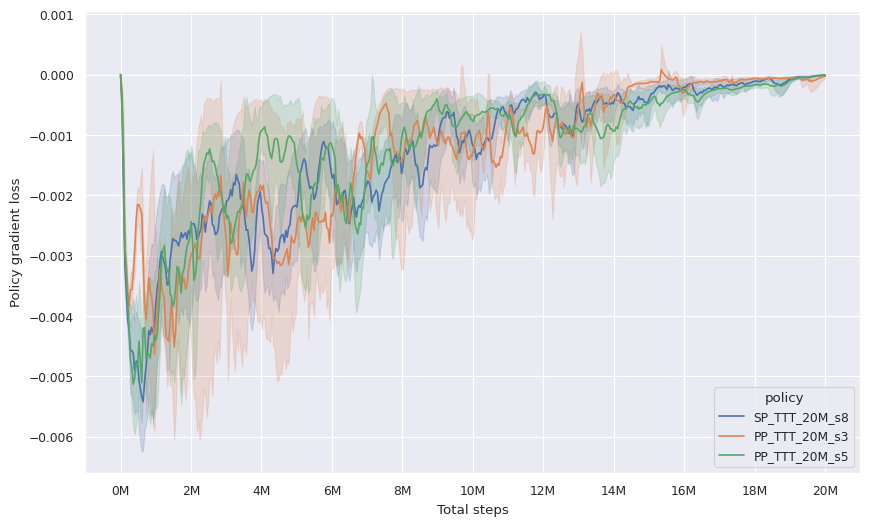

In [10]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/policy_gradient_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Policy gradient loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_policy_gradient_loss.pdf'), bbox_inches='tight')

Plot value function loss

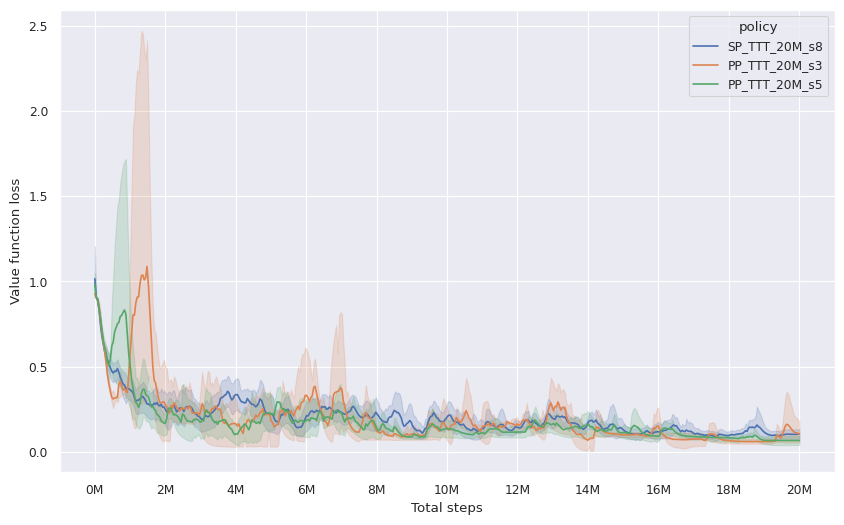

In [11]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='loss/value_function_loss_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Value function loss')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_value_function_loss.pdf'), bbox_inches='tight')

Read eventfiles and output pandas DataFrame for episode reward data

In [12]:
def read_episode_data(policy_name, size, env_step, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for folder in os.scandir(os.path.join(data_dir, policy_name, 'logs')):
        if folder.is_dir():
            logdir = os.path.join(folder, 'tb_1', 'events*')
            eventfile = glob.glob(logdir)[0]
            data_dict = get_section_results(eventfile, policy_name, 'episode_reward')
            data = pd.DataFrame(data_dict)
            for (columnName, columnData) in data.items():
                if columnName != 'env_step' and columnName != 'policy':
                    data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

            # reduce size for plotting
            count_row = data.shape[0]
            reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
            data_p = data.iloc[reduced_row]
            # align env_step
            aligned_step = np.linspace(0, env_step, size, dtype=int, endpoint=True)
            data_p.loc[:, 'env_step'] = aligned_step

            full_data = pd.concat([full_data, data], axis=0)
            plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

Read episode reward data

In [13]:
PP_s5_ep, PP_s5_plot_ep = read_episode_data('PP_TTT_20M_s5',500, 2e7, 0.00001)
PP_s3_ep, PP_s3_plot_ep = read_episode_data('PP_TTT_20M_s3',500, 2e7, 0.00001)
SP_s8_ep, SP_s8_plot_ep = read_episode_data('SP_TTT_20M_s8',500, 2e7, 0.00001)

data_ep_plot = pd.concat([SP_s8_plot_ep, PP_s3_plot_ep, PP_s5_plot_ep], axis=0)

/tmp/ipykernel_14537/177716668.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p.loc[:, 'env_step'] = aligned_step
/tmp/ipykernel_14537/177716668.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p.loc[:, 'env_step'] = aligned_step
/tmp/ipykernel_14537/177716668.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Plot episode reward

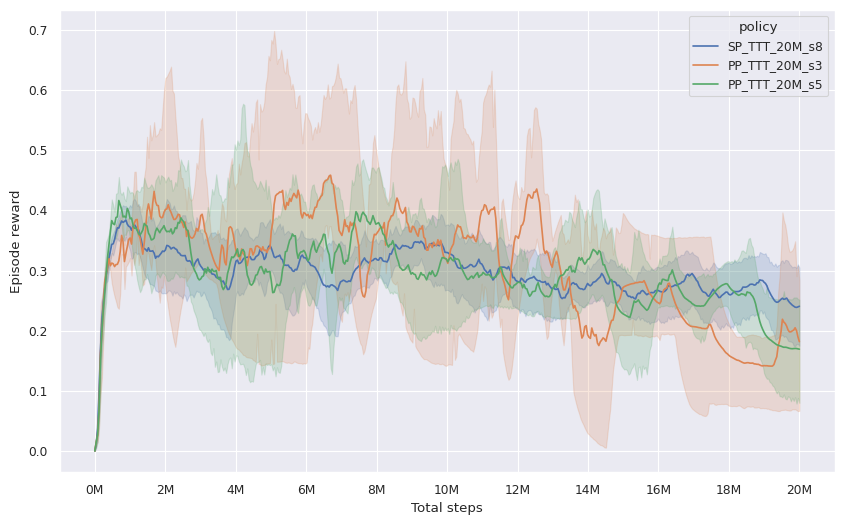

In [14]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_ep_plot, x='env_step', y='episode_reward_smooth', hue='policy')
ax.set(xlabel='Total steps', ylabel='Episode reward')
plt.xticks(np.arange(0, 21e6, 2e6))
xlabels = ['{:.0f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'tictactoe_episode_reward.pdf'), bbox_inches='tight')